<a href="https://colab.research.google.com/github/ibader85/UnstructuredDataAnalytics/blob/main/13_Advanced_Topics_Text_Analysis_using_SVM_Naieve_Bayes_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

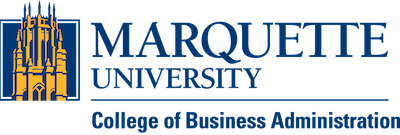

#BUAN4060: Unstructured Data Analytics

##13 Text Analysis using SVM & Naieve Bayes

##Instructor: Dr. Badar Al Lawati "Dr. B"

**Acknowledgment:** This material is based on the content created by `[Alexandre KOWALCZYK](https://www.svm-tutorial.com/2014/11/svm-classify-text-r/)'
**R on Colab:**

* You can change the runtime from Python to R, by clicking on the down arrow next to Connect, and picking "Change Runtime Type"

* You can change the project name by clicking on the title on top of this page

* You can export your notebook by going to File > Download .ipynb

# SVM Text Analysis

## 	1.	Install and Load Necessary Package:
To easily classify text with SVM,  we will use the [RTextTools package](http://cran.r-project.org/web/packages/RTextTools/RTextTools.pdf)

In [1]:
# Install packages if needed
install.packages("RTextTools")

# Load libraries
library(RTextTools)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘iterators’, ‘NLP’, ‘slam’, ‘BH’, ‘proxy’, ‘prodlim’, ‘bitops’, ‘foreach’, ‘shape’, ‘RcppEigen’, ‘SparseM’, ‘randomForest’, ‘tree’, ‘tm’, ‘e1071’, ‘ipred’, ‘caTools’, ‘glmnet’, ‘tau’


Loading required package: SparseM



##	2.	Read the Data:
For this tutorial we will use a very simple data set [click to download](https://mega.co.nz/#!RINGEJKA!yrYFtfMPpLUOHye1YTC1SuYbAx6IKDJyG5uC_4N8R4M)

With just a few lines of R, we load the data in memory

In [3]:
# Load the data from the csv file
data <- read.csv(paste('/content/sunnyData.csv', sep=""), header = TRUE)

head(data)

,Text,IsSunny
,<chr>,<int>
1,sunny,1
2,rainy,-1
3,sunny sunny,1
4,sunny rainy,-1
5,rainy sunny,-1
6,rainy rainy,-1


## 	3. Prepare the data:
The data has two columns: Text and IsSunny

We will need to convert it to a **Document Term Matrix**

Using RTextTools: The RTextTools package provides a powerful way to generate document term matrix with the create_matrix function

In [4]:
# Create the document term matrix
dtMatrix <- create_matrix(data["Text"])

# View cleaned data
head(dtMatrix)

Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom functions are ignored”
Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom tokenizer is ignored”


<<DocumentTermMatrix (documents: 6, terms: 2)>>
Non-/sparse entries: 8/4
Sparsity           : 33%
Maximal term length: 5
Weighting          : term frequency (tf)

## 	4. Create and train the SVM model:
In order to train a SVM model with RTextTools, we need to put the document term matrix inside a container

In the container's configuration, we indicate that the whole data set will be the training set

In [5]:
# Configure the training data
container <- create_container(dtMatrix, data$IsSunny, trainSize=1:11, virgin=FALSE)

# train a SVM Model
model <- train_model(container, "SVM", kernel="linear", cost=1)

##5. Predict with new data

Now that our model is trained, we can use it to make new predictions !

We will create new sentences which were not in the training data:

In [6]:
# new data
predictionData <- list("sunny sunny sunny rainy rainy", "rainy sunny rainy rainy", "hello", "", "this is another rainy world")

Before continuing, let's check the new sentences :

- "sunny sunny sunny rainy rainy"
This sentence talks more about the sunny weather than the rainy. We expect it to be classified as sunny (+1)
- "rainy sunny rainy rainy"
This sentence talks more about the rainy weather than the sunny. We expect it to be classified as rainy (-1)
- ""
This sentence has no word, it should return either +1 or -1 in function of the decision boundary
- "hello"
This sentence has a word which was not present in the training set. It will be equivalent to ""
- "this is another rainy world"
This sentence has several worlds not in the training set, and the word rainy. It is equivalent to the sentence "rainy" and should be classified "-1"

We create a document term matrix for the test data:

In [7]:
# create a prediction document term matrix
predMatrix <- create_matrix(predictionData, originalMatrix=dtMatrix)

Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom functions are ignored”
Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom tokenizer is ignored”


Notice that this time we provided the originalMatrix as a parameter. This is because **we want the new matrix to use the same vocabulary as the training matrix**

Without this indication, the function will create a document term matrix using all the words of the test data (rainy, sunny, hello, this, is, another, world). It means that each sentence will be represented by a vector containing 7 values (one for each word) !

Such a matrix won't be compatible with the model we trained earlier because it expect vectors containing 2 values (one for rainy, one for sunny).

We now create the container:

In [8]:
# create the corresponding container
predSize = length(predictionData);
predictionContainer <- create_container(predMatrix, labels=rep(0,predSize), testSize=1:predSize, virgin=FALSE)

Two things are different:

- we use a zero vector for labels, because we want to predict them
- we specified **testSize** instead of **trainingSize** so that the data will be used for testing

Eventually, we can make predictions:

In [9]:
# predict
results <- classify_model(predictionContainer, model)
results

,SVM_LABEL,SVM_PROB
,<chr>,<dbl>
1,1,0.7662103
2,-1,0.9319283
3,-1,0.5202077
4,-1,0.5202077
5,-1,0.7939308


As expected the first sentence has been classified as sunny and the second and last one as rainy.

We can also see that the third and fourth sentences  ("hello" and "") have been classified as rainy, but the probability is only  52% which means our model is not very confident on these two predictions